# Exploratory analysis

In this section, we are going to look into the dataset, explore the features, and draw plots. The goal is to hopefully figure out which features to throw out and how to transform the remaining attributes.

So, without further ado, ladies and gentlement, let's **analyze the dataset**!

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn import preprocessing
from scipy.stats import boxcox

sb.set_style('dark')

## Dataset description

The dataset is from the [NetCla challenge](http://www.neteye-blog.com/netcla-the-ecml-pkdd-network-classification-challenge/). One data point corresponds to one http transmission. Various metrics (features) are measured for each transmission. The goal is to train a model that, for each data point, predicts the type of the application that is transmitting the data. This is a multi-classification task.

## Loading the data

Let's start by loading the dataset. The training data is split into 2 CSV files, so we'll load both of them and merge them into one dataframe.

In [2]:
data_train = pd.read_csv('data/train.csv', delimiter='\t', header=0)
data_train.shape

(761179, 49)

In [3]:
data_target = pd.read_csv('data/train_target.csv', delimiter='\t', header=None)
data_target.shape

(761179, 1)

In [4]:
data = pd.concat([data_train, data_target], axis=1)
data.shape

(761179, 50)

## Analyzing features

Now that we have the dataset, let's look into the features of the dataset.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761179 entries, 0 to 761178
Data columns (total 50 columns):
cli_pl_header          761179 non-null int64
cli_pl_body            761179 non-null int64
cli_cont_len           761179 non-null int64
srv_pl_header          761179 non-null int64
srv_pl_body            761179 non-null int64
srv_cont_len           761179 non-null int64
aggregated_sessions    761179 non-null int64
bytes                  761179 non-null int64
net_samples            761179 non-null int64
tcp_frag               761179 non-null int64
tcp_pkts               761179 non-null int64
tcp_retr               761179 non-null int64
tcp_ooo                761179 non-null int64
cli_tcp_pkts           761179 non-null int64
cli_tcp_ooo            761179 non-null int64
cli_tcp_retr           761179 non-null int64
cli_tcp_frag           761179 non-null int64
cli_tcp_empty          761179 non-null int64
cli_win_change         761179 non-null int64
cli_win_zero           761179 non-

All features are numerical and non-null. The target is called `0` so let's rename it to `target`.

In [6]:
data.rename(columns={0: 'target'}, inplace=True)

Now let's see the statistics of the features.

In [7]:
described_data = data.describe().transpose()
described_data

,count,mean,std,min,25%,50%,75%,max
cli_pl_header,761179.0,767.099598,7.533905e+02,38.000000,383.000000,572.000000,908.000000,2.425300e+04
cli_pl_body,761179.0,304.696489,8.206498e+03,0.000000,0.000000,0.000000,0.000000,4.604503e+06
cli_cont_len,761179.0,302.262439,7.776122e+03,0.000000,0.000000,0.000000,0.000000,2.538295e+06
srv_pl_header,761179.0,429.038246,3.483471e+02,17.000000,295.000000,363.000000,476.000000,4.031500e+04
srv_pl_body,761179.0,38322.128096,7.139453e+05,0.000000,114.000000,1362.000000,9577.000000,1.118097e+08
srv_cont_len,761179.0,103110.714821,1.018259e+07,0.000000,43.000000,951.000000,6924.000000,2.147484e+09
aggregated_sessions,761179.0,1.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000e+00
bytes,761179.0,62074.214734,1.050580e+06,425.000000,2786.000000,5637.000000,18610.000000,2.355868e+08
net_samples,761179.0,0.999982,4.288614e-03,0.000000,1.000000,1.000000,1.000000,1.000000e+00
tcp_frag,761179.0,0.000012,4.725851e-03,0.000000,0.000000,0.000000,0.000000,2.000000e+00


There are a few features that contain just a single value. These can be safely thrown out.

In [8]:
single_value_columns = described_data[described_data['std'] == 0].index
single_value_columns

Index(['aggregated_sessions', 'cli_tcp_frag', 'sp_error'], dtype='object')

In [9]:
data = data.drop(single_value_columns, axis=1)

Now let's look into the number of unique values for each feature. Features that only have a few values can probably be thrown out.

In [10]:
nunique = data.apply(pd.Series.nunique)
nunique.sort_values()

sp_healthscore              2
proxy                       2
net_samples                 2
srv_tcp_frag                3
tcp_frag                    3
target                     20
srv_win_zero               42
sp_is_lat                  50
cli_win_zero               52
cli_pl_change              62
cli_tcp_retr               92
cli_tcp_ooo               115
cli_tcp_full              156
srv_tcp_empty             166
srv_pl_change             326
sp_req_duration           371
srv_win_change            620
cli_win_change            773
srv_tcp_retr             1179
tcp_retr                 1183
srv_tcp_ooo              1678
tcp_ooo                  1686
cli_tcp_pkts             1865
cli_tcp_empty            1868
srv_tcp_full             2351
srv_tcp_pkts             2544
srv_pl_header            2689
cli_cont_len             2860
tcp_pkts                 3428
cli_pl_body              3504
cli_pl_header            5447
cli_pl_tot               7314
srv_tcp_win             10634
cli_tcp_wi

If we look into the [description of features](http://www.neteye-blog.com/netcla-the-ecml-pkdd-network-classification-challenge/), we can see what are these supposed to represent. `proxy` is a boolean that indicates whether a proxy has been used, we'll leave that. We'll throw the rest out.

In [11]:
few_nunique = nunique[(nunique < 5) & (nunique.index != 'proxy')].index

In [12]:
data = data.drop(few_nunique, axis=1)

## NAs

Are there any missing values in the dataset?

In [13]:
data.dropna().shape != data.shape

False

And the answer is....... `False`! Thank god. We can focus on more important problems.

## Visualization

In this part, there are going to be lots of plots. Visualizing the data is crutial to better understand it. Hopefully we can throw out some more features.

Let's start with the famous correlation matrix.

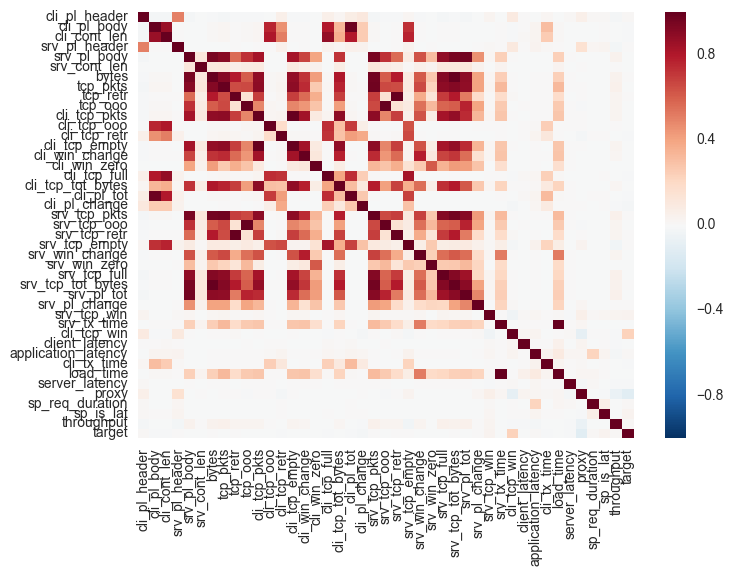

In [14]:
correlations = data.corr()
sb.heatmap(correlations)

As we can see, a lot of features are correlated. As expected, no feature is correlated with the `target` because it is a categorical variable. Let's further look into the `target`.

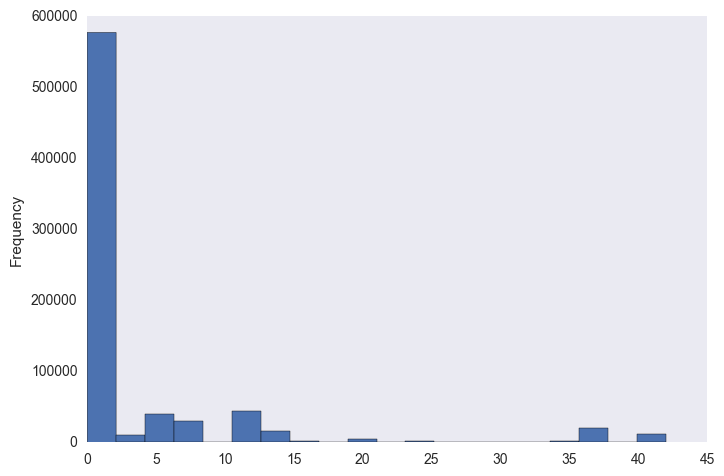

In [15]:
data.target.plot.hist(bins=20)

The majority of the data points are classified as `Unknown application`. Oh well, it's a categorical variable so it can't be normalized. Let's look into histograms of other features. A lot of plots incoming!

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110b39be0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1182f3630>]], dtype=object)

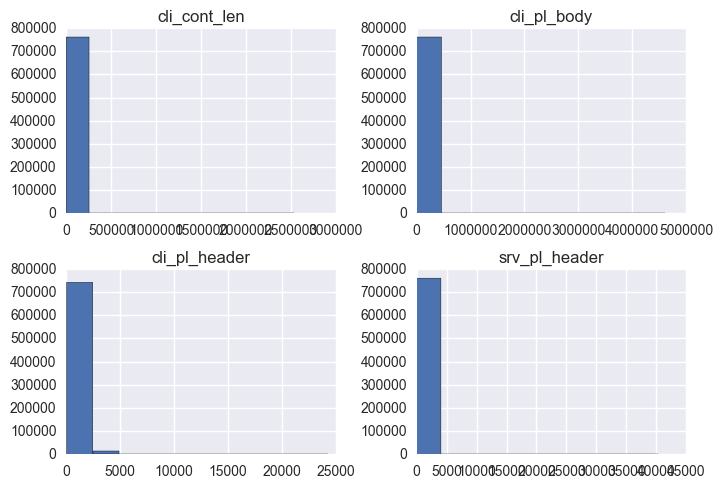

In [16]:
data[data.columns[0:4]].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1110a8b00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1123dee48>]], dtype=object)

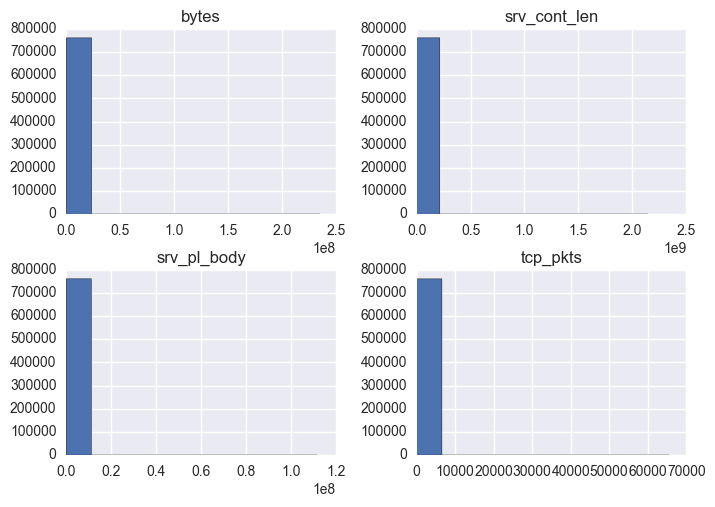

In [17]:
data[data.columns[4:8]].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112430a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x112769518>]], dtype=object)

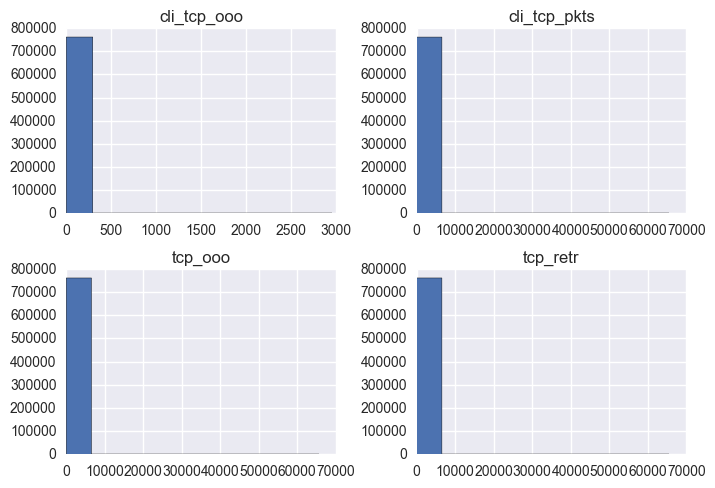

In [18]:
data[data.columns[8:12]].hist()

This is just a half of the features, but it can be seen that all of them have very long tails. A logarithmic or, better yet, box-cox transformation is required to normalize the features. Before we do that, let's draw one final plot for the `proxy` feature.

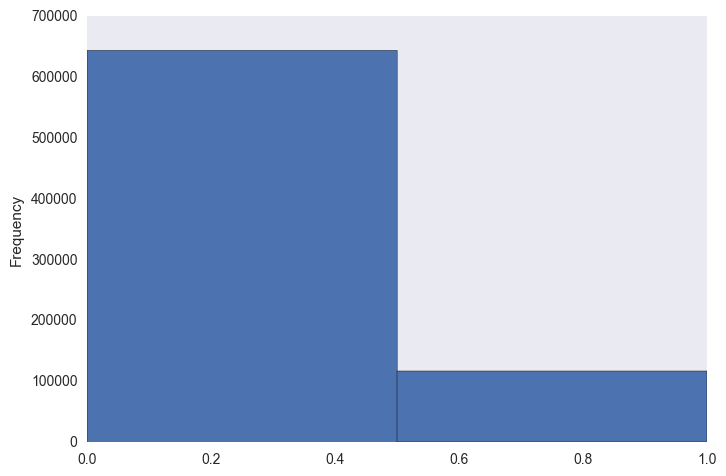

In [19]:
data.proxy.plot.hist(bins=2)

Most data points don't use a proxy, however a lot of them do. This feature can't be transformed because it represents a boolean flag.

## Normalization

[Scikit-learn documentation about preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling) mentions that all predictors should be normalized to have 0 mean and unit variance. However, we need to normalize only continuous features. After reading the [description of the features](http://www.neteye-blog.com/netcla-the-ecml-pkdd-network-classification-challenge/), all features are continuous. The only exception is `proxy` which is a boolean flag. Moreover, almost all features have long tails so they also need to be transformed using Box-cox.

In [20]:
data.head().lt(0).sum()

cli_pl_header          0
cli_pl_body            0
cli_cont_len           0
srv_pl_header          0
srv_pl_body            0
srv_cont_len           0
bytes                  0
tcp_pkts               0
tcp_retr               0
tcp_ooo                0
cli_tcp_pkts           0
cli_tcp_ooo            0
cli_tcp_retr           0
cli_tcp_empty          0
cli_win_change         0
cli_win_zero           0
cli_tcp_full           0
cli_tcp_tot_bytes      0
cli_pl_tot             0
cli_pl_change          0
srv_tcp_pkts           0
srv_tcp_ooo            0
srv_tcp_retr           0
srv_tcp_empty          0
srv_win_change         0
srv_win_zero           0
srv_tcp_full           0
srv_tcp_tot_bytes      0
srv_pl_tot             0
srv_pl_change          0
srv_tcp_win            0
srv_tx_time            0
cli_tcp_win            0
client_latency         0
application_latency    0
cli_tx_time            0
load_time              0
server_latency         0
proxy                  0
sp_req_duration        0


There are no negative values in the dataset, so let's proceed.

In [21]:
data_transformed = data.drop(['proxy', 'target'], axis=1).apply(lambda x: boxcox(x + 1)[0], raw=True)

In [22]:
data_norm = pd.DataFrame(preprocessing.StandardScaler().fit_transform(data_transformed))
data_norm.columns = data.drop(['proxy', 'target'], axis=1).columns
data_norm[['proxy', 'target']] = data[['proxy', 'target']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11288c128>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10c1b69b0>]], dtype=object)

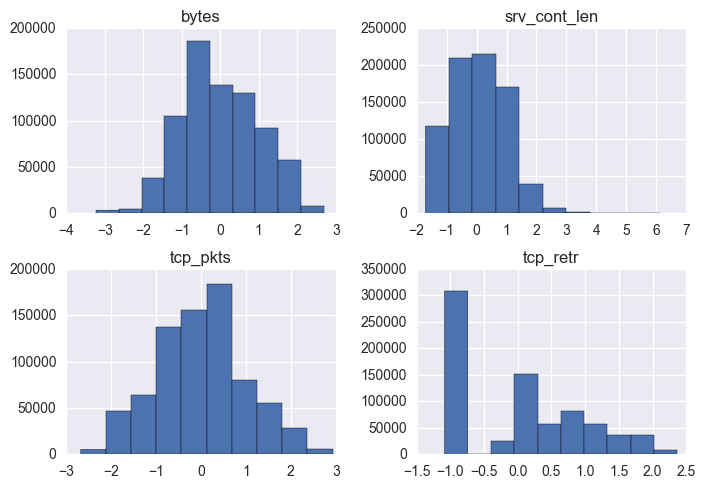

In [23]:
data_norm[data_norm.columns[5:9]].hist()

Now we can see that the data has more normalized distribution.

## Training basic models

Before we get into feature engineering, let's try to train 2 basic models to see how precise they will be. We will be training a decision tree and a naive bayes model on a subset of the normalized data.

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score

In [44]:
tree = DecisionTreeClassifier().fit(data_norm[:100000].drop('target', axis=1), data_norm.target[:100000])
bayes = GaussianNB().fit(data_norm[:100000].drop('target', axis=1), data_norm.target[:100000])

Now calculate the F1 score for each model.

In [45]:
f1_score(data_norm.target[:100000], tree.predict(data_norm[:100000].drop('target', axis=1)), average='macro')

1.0

In [46]:
f1_score(data_norm.target[:100000], bayes.predict(data_norm[:100000].drop('target', axis=1)), average='macro')

0.6225207606159503

Well, the decision tree model predicted correct application for all data points. It is obviously overfitted. The naive bayes model has an F1 score of `0.6225`. Let's try improving this score by creating new features, using cross validation and the test dataset.